In [1]:
%load_ext autoreload
%autoreload 2

### QWEN 2.5

In [7]:
import numpy as np

In [2]:
from analysis.utils import load_extractions

folder = "extractions/Qwen_Qwen2.5-VL-3B-Instruct_VSR"

data = load_extractions(folder, keys=["attns", "image_positions", "text_positions"])

In [29]:
attn, image_positions, text_positions = data['attns'], data['image_positions'], data['text_positions']

In [66]:
from analysis.attention import compute_attention_ratios, compute_attention_ratios2

im1, _ = compute_attention_ratios2(attn, image_positions)
im2, _ = compute_attention_ratios(attn, image_positions)

(np.float16(1344.0), np.float16(1344.0))

In [68]:
from data import get_dataset

dataset = get_dataset("VSR")

1222it [00:00, 1389007.99it/s]


In [126]:
sample = dataset[100]
sample

{'image_options': [<PIL.Image.Image image mode=RGB size=2300x4096>],
 'caption_options': ['The cat is in the sink.'],
 'labels': [1]}

{'image_options': [<PIL.Image.Image image mode=RGB size=2300x4096>],
 'caption_options': ['The car is behind the suitcase.'],
 'labels': [1]}

In [127]:
import torch
from transformers import AutoProcessor
from qwen_vl_utils import process_vision_info

MAX_PIXELS = 256 * 28 * 28

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", max_pixels = MAX_PIXELS)

#image = "https://picsum.photos/512"
image = sample['image_options'][0]
prompt = "Give me three facts about this image"
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text",  "text": prompt},
        ],
    },
    {"role": "system", "content": "You are a helpful assistant."}
]


text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, _ = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=None,
    padding=True,
    return_tensors="pt",
)

inputs.image_grid_thw, inputs.pixel_values.shape

(tensor([[ 1, 42, 22]]), torch.Size([924, 1176]))

In [117]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=None,
    padding=True,
    return_tensors="pt",
)

inputs.image_grid_thw, inputs.pixel_values.shape, (inputs.input_ids == 151655).sum()

(tensor([[ 1, 42, 22]]), torch.Size([924, 1176]), tensor(231))

In [154]:
image = sample['image_options'][0]

In [152]:
orig_w = 2300
orig_h = 4096

patch  = processor.image_processor.patch_size     # 14 px
merge  = processor.image_processor.merge_size     # 2 by default
print(patch, merge)

_, H_grid, W_grid = inputs.image_grid_thw[0].tolist()  # e.g. 42×22

H_tok, W_tok = H_grid // merge, W_grid // merge        # 21×11 → 231

H_real = H_grid * patch                           # 588
W_real = W_grid * patch                           # 308

sx = orig_w / W_real
sy = orig_h / H_real

14 2


In [146]:
sx, sy

(13.2987012987013, 3.9115646258503403)

In [150]:
x0, y0, x1, y1

(3724, 2190, 4096, 2300)

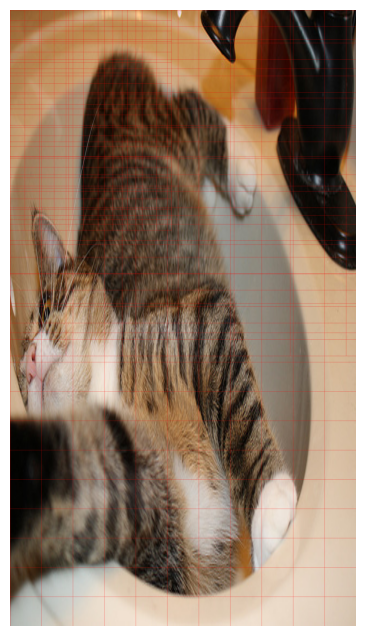

In [153]:
import torch
from transformers import AutoProcessor
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

draw = ImageDraw.Draw(image)

for k in range(231):   # k = 0..230
    row, col = divmod(k, W_tok)               # token’s row/col in merged grid

    # top-left raw patch of this merged token
    r0_p, c0_p = row * merge, col * merge

    # bounding box in **processed** coords
    x0_p = c0_p * patch
    y0_p = r0_p * patch
    x1_p = (c0_p + merge) * patch
    y1_p = (r0_p + merge) * patch

    # scale to original resolution
    x0 = int(round(x0_p * sx));  y0 = int(round(y0_p * sy))
    x1 = int(round(x1_p * sx));  y1 = int(round(y1_p * sy))

    draw.rectangle([x0, y0, x1, y1], outline="red", width=1)

# ---------------------------------------------------------
# 4.  Display
# ---------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info


# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
).cuda()

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

image = "https://picsum.photos/512"
prompt = "Give me three facts about this image"
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text",  "text": prompt},
        ],
    },
    {"role": "system", "content": "You are a helpful assistant."}
]

batch_messages = [messages]
text_inputs = [
    processor.apply_chat_template(
            msgs, tokenize=False, add_generation_prompt=True
        )
        for msgs in batch_messages
]
# Preparation for inference
# text = processor.apply_chat_template(
#     messages, tokenize=False, add_generation_prompt=True
# )
image_inputs, video_inputs = process_vision_info(batch_messages)
inputs = processor(
    text=text_inputs,
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

In [ ]:
inputs

In [ ]:
model_name = "Qwen/Qwen2.5-VL-asd"
key = model_name.lower().split("/")[1]

key

In [4]:
outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

In [ ]:
outputs.logits

In [ ]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


### InternVL 3

In [20]:
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [ ]:
# If you set `load_in_8bit=True`, you will need two 80GB GPUs.
# If you set `load_in_8bit=False`, you will need at least three 80GB GPUs.
path = 'OpenGVLab/InternVL3-1B'
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    load_in_8bit=False,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

# set the max number of tiles in `max_num`
pixel_values = load_image('example.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=True)

# single-image single-round conversation (单图单轮对话)
question = '<image>\nPlease describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig

path = "OpenGVLab/InternVL3-1B"
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    device_map="auto").eval()

tokenizer = AutoTokenizer.from_pretrained(
    path,
    trust_remote_code=True,
    use_fast=False,
)

pixel_values = load_image("example.jpg", max_num=12).to(torch.bfloat16).cuda()

question = "<image>\nPlease describe the image shortly."

inputs = tokenizer(
    question,
    return_tensors="pt",
)

#inputs = {k: v.cuda() for k, v in inputs.items()}

# Attach the image tensors under the keyword the model expects
# (here we assume it’s just “pixel_values”)
inputs["pixel_values"] = pixel_values

# 4) Configure generation parameters
gen_config = GenerationConfig(
    max_new_tokens=1024,
    do_sample=True,
    top_p=0.9,
    temperature=0.7,
)

generated_ids = model.generate(
    **inputs,
    generation_config=gen_config,
)

full_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
if full_output.startswith(question):
    response = full_output[len(question):].strip()
else:
    response = full_output.strip()

print(f"User: {question}\nAssistant: {response}")
